## 1. Import Libraries

In [244]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchview import draw_graph

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from tqdm import tqdm
import glob
from pathlib import Path

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'pkill' is not recognized as an internal or external command,
operable program or batch file.


PyTorch version: 2.9.1+cu128
Device: cuda


A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file models already exists.
Error occurred while processing: models.


## **2. Data Loading**

In [245]:
base_path = Path.cwd().resolve()

datasets_path = base_path / "an2dl2526c2"
if not datasets_path.exists():
    fallback_path = base_path.parent / "an2dl2526c2"
    if fallback_path.exists():
        datasets_path = fallback_path
    else:
        raise FileNotFoundError(f"Dataset folder not found at {datasets_path} or {fallback_path}")

train_data_path = datasets_path / "train_data"
train_labels_path = datasets_path / "train_labels.csv"
test_data_path = datasets_path / "test_data"
output_path = datasets_path / "train_masked"

print(f"Dataset path: {datasets_path}")
print(f"Train data path: {train_data_path}")
print(f"Train labels path: {train_labels_path}")
print(f"Test data path: {test_data_path}")
print(f"Output path: {output_path}")

CSV_PATH = str(train_labels_path)
SOURCE_FOLDER = str(train_data_path)
OUTPUT_FOLDER = str(output_path)
if not Path(SOURCE_FOLDER).exists():
    candidate_datasets = [
        datasets_path,
        base_path.parent / "an2dl2526c2",
        Path(r"C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2"),
    ]
    for candidate in candidate_datasets:
        if candidate.exists():
            datasets_path = candidate
            train_data_path = datasets_path / "train_data"
            train_labels_path = datasets_path / "train_labels.csv"
            test_data_path = datasets_path / "test_data"
            output_path = datasets_path / "train_masked"

            CSV_PATH = str(train_labels_path)
            SOURCE_FOLDER = str(train_data_path)
            OUTPUT_FOLDER = str(output_path)

            print(f"Resolved dataset path: {datasets_path}")
            break
    else:
        raise FileNotFoundError(
            "Dataset folder not found in any of the candidate locations:\n"
            + "\n".join(str(p) for p in candidate_datasets)
        )


Dataset path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2
Train data path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\train_data
Train labels path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\train_labels.csv
Test data path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\test_data
Output path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\train_masked


In [246]:
def apply_mask(image_path, mask_path, output_path, target_size=(224, 224)):
    """
    Loads an image and a mask, resizes them, applies the mask, and saves the result.
    """
    # 1. Load Image
    img = cv2.imread(str(image_path))
    if img is None:
        tqdm.write(f"Error: Could not load image at {image_path}")
        return

    # 2. Load Mask (Read as grayscale)
    mask = cv2.imread(str(mask_path), 0)
    if mask is None:
        tqdm.write(f"Error: Could not load mask at {mask_path}")
        return

    # 3. Resize both to target size
    if target_size is not None:
        # Resize image using linear interpolation (better for photos)
        img = cv2.resize(img, target_size)
        # Resize mask using nearest neighbor to preserve sharp edges
        mask = cv2.resize(mask, target_size)

    # 4. Ensure mask is strictly binary (0 or 255)
    # Values > 127 become 255 (White), others become 0 (Black)
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # 5. Apply the mask
    # cv2.bitwise_and keeps the pixel where the mask is 255, and makes it 0 where mask is 0
    masked_img = cv2.bitwise_and(img, img, mask=binary_mask)

    # 6. Save result
    cv2.imwrite(str(output_path), masked_img)

In [247]:
def process_batch(input_dir, output_dir, target_size=(224, 224)):
    """
    Iterates through input_dir, finds pairs of 'img_xxxx' and 'mask_xxxx',
    resizes them to target_size, and saves the masked result to output_dir.
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    
    # Create output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Extensions to look for
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    
    # 1. Gather all valid image files first
    print(f"Scanning for images in: {input_dir}...")
    image_files = [
        f for f in input_dir.iterdir() 
        if f.name.startswith('img_') and f.suffix.lower() in valid_extensions
    ]
    
    if not image_files:
        print("No images found starting with 'img_' in the directory.")
        return

    # 2. Iterate with tqdm
    count = 0
    
    for file_path in tqdm(image_files, desc="Processing Images", unit="img"):
        # Construct expected mask filename: img_123.jpg -> mask_123.jpg
        mask_name = file_path.name.replace('img_', 'mask_', 1)
        mask_path = input_dir / mask_name
        
        # Fallback: If mask_123.jpg doesn't exist, try mask_123.png
        if not mask_path.exists():
            mask_stem = file_path.stem.replace('img_', 'mask_', 1)
            mask_path = input_dir / (mask_stem + ".png")
        
        if mask_path.exists():
            output_path = output_dir / file_path.name
            
            if output_path.exists():
                # Skip silently
                continue

            apply_mask(file_path, mask_path, output_path, target_size=target_size)
            count += 1
        else:
            # Use tqdm.write to log errors without breaking the progress bar
            tqdm.write(f"Skipping {file_path.name}: No matching mask found (looked for {mask_name})")

    print(f"Batch processing complete. Processed {count} new images.")

In [248]:
def load_images_from_folder(folder):
    """
    Load and preprocess images from a specified folder with a progress bar.

    Args:
        folder (str): Path to the folder containing images

    Returns:
        np.ndarray: Array of preprocessed images with shape (N, H, W, C)
    """
    images = []
    
    # Get the list of files to iterate over
    file_list = os.listdir(folder)

    # Iterate through files with a tqdm progress bar
    for filename in tqdm(file_list, desc=f"Loading images from {os.path.basename(folder)}"):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)

        # Check if image was loaded successfully right away
        if img is None:
            print(f"Warning: Failed to load image at {img_path}. Skipping.")
            continue

        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255.0).astype(np.float32)

        # Convert image from BGR to RGB
        img = img[..., ::-1]

        #NOTE: commented out because the images are already resized
        # Crop the image to be square
        # dim = min(img.shape[:2])
        # start_y = (img.shape[0] - dim) // 2
        # start_x = (img.shape[1] - dim) // 2
        # img = img[start_y:start_y+dim, start_x:start_x+dim, :]

        # NOTE: commented out because the images are already resized
        # Resize the image to 224x224 pixels 
        # img = cv2.resize(img, (224, 224))

        images.append(img)

    return np.array(images)

In [249]:
source_dir = Path(SOURCE_FOLDER)
output_dir = Path(OUTPUT_FOLDER)

if not source_dir.exists():
	print(f"Warning: source directory '{source_dir}' not found. Creating an empty directory. Please populate it with images before running the pipeline.")
	source_dir.mkdir(parents=True, exist_ok=True)

output_dir.mkdir(parents=True, exist_ok=True)

process_batch(str(source_dir), str(output_dir), target_size=(224, 224))
MASKED_IMAGE_PATH = str(output_dir)

Scanning for images in: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\train_data...


Processing Images: 100%|██████████| 1412/1412 [00:00<00:00, 8919.24img/s]

Batch processing complete. Processed 0 new images.


In [250]:
train_images = load_images_from_folder(MASKED_IMAGE_PATH)
print(f"Loaded {len(train_images)}  images")


Loading images from train_masked: 100%|██████████| 1412/1412 [00:01<00:00, 834.44it/s]



Loaded 1412  images


## **3. Exploration and Data Analysis**

In [251]:
# Add this cell before your visualization
print(f"MASKED_IMAGE_PATH: {MASKED_IMAGE_PATH}")
print(f"Path exists: {Path(MASKED_IMAGE_PATH).exists()}")
print(f"Number of files: {len(os.listdir(MASKED_IMAGE_PATH)) if Path(MASKED_IMAGE_PATH).exists() else 0}")
print(f"train_images shape: {train_images.shape}")

MASKED_IMAGE_PATH: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\train_masked
Path exists: True
Number of files: 1412
train_images shape: (1412, 224, 224, 3)


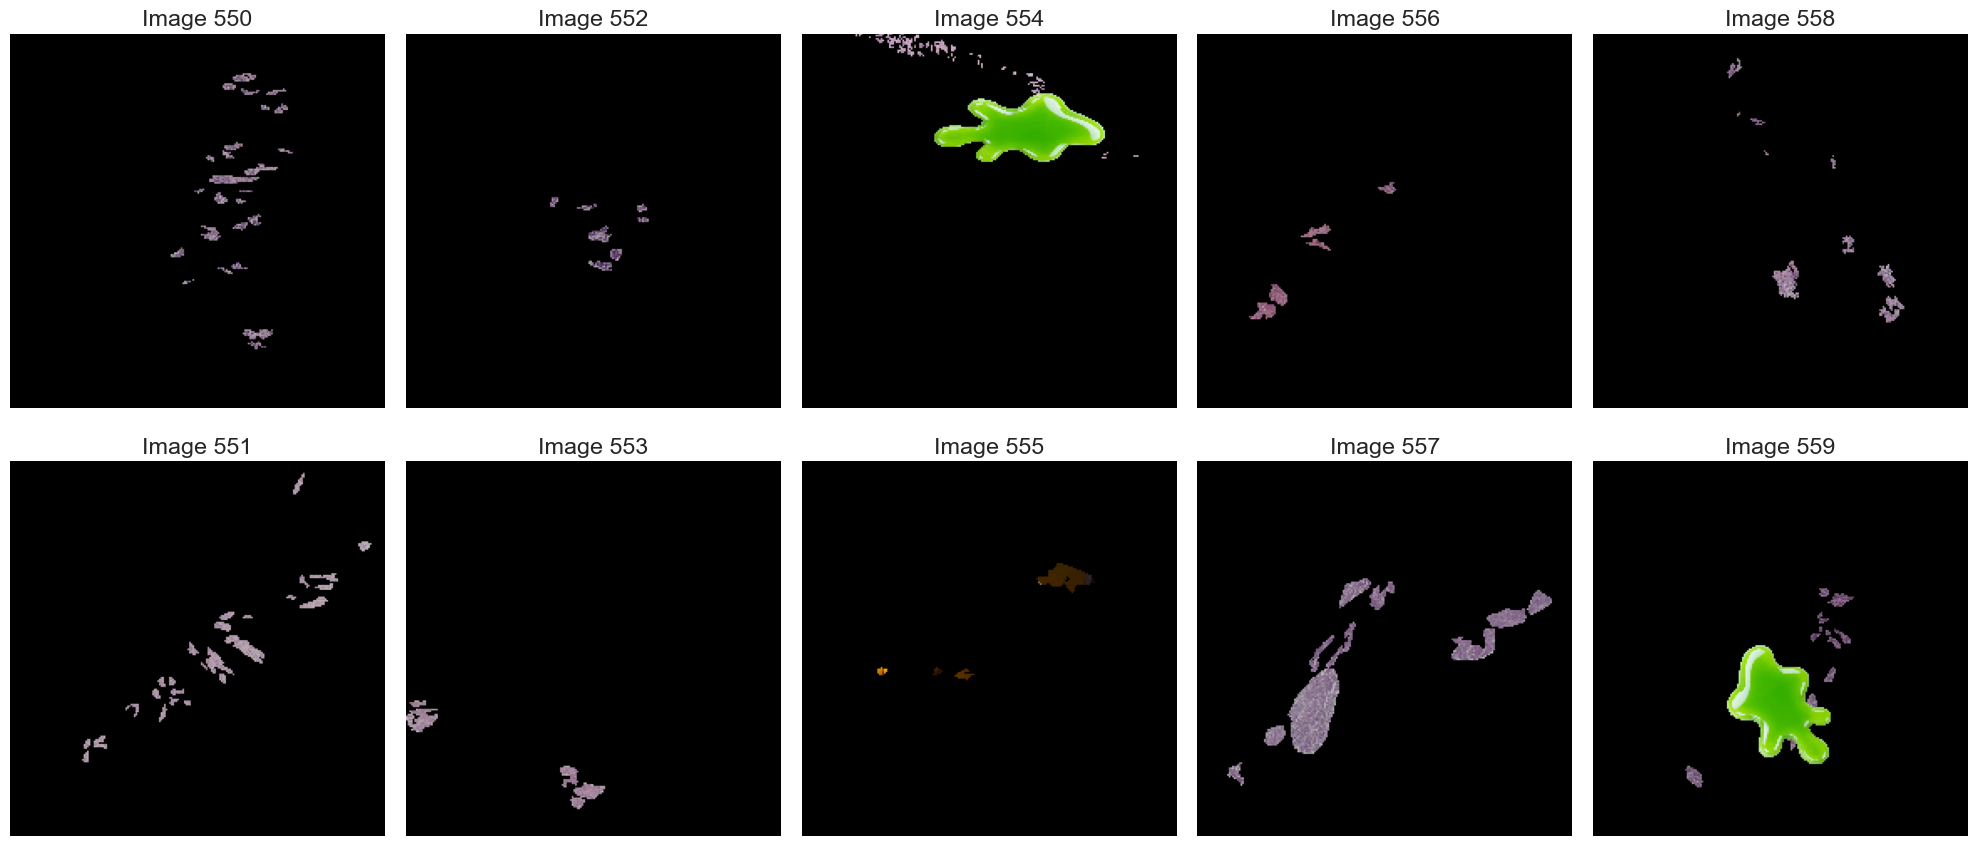

In [252]:
# Number of images to display
num_img = 10
start_img= 550
# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(start_img, start_img+num_img):
    ax = axes[i%2, i%num_img//2]
    # Add the image index into the imageshow
    ax.set_title(f"Image {i}")
    ax.imshow(np.clip(train_images[i], 0, 1))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()



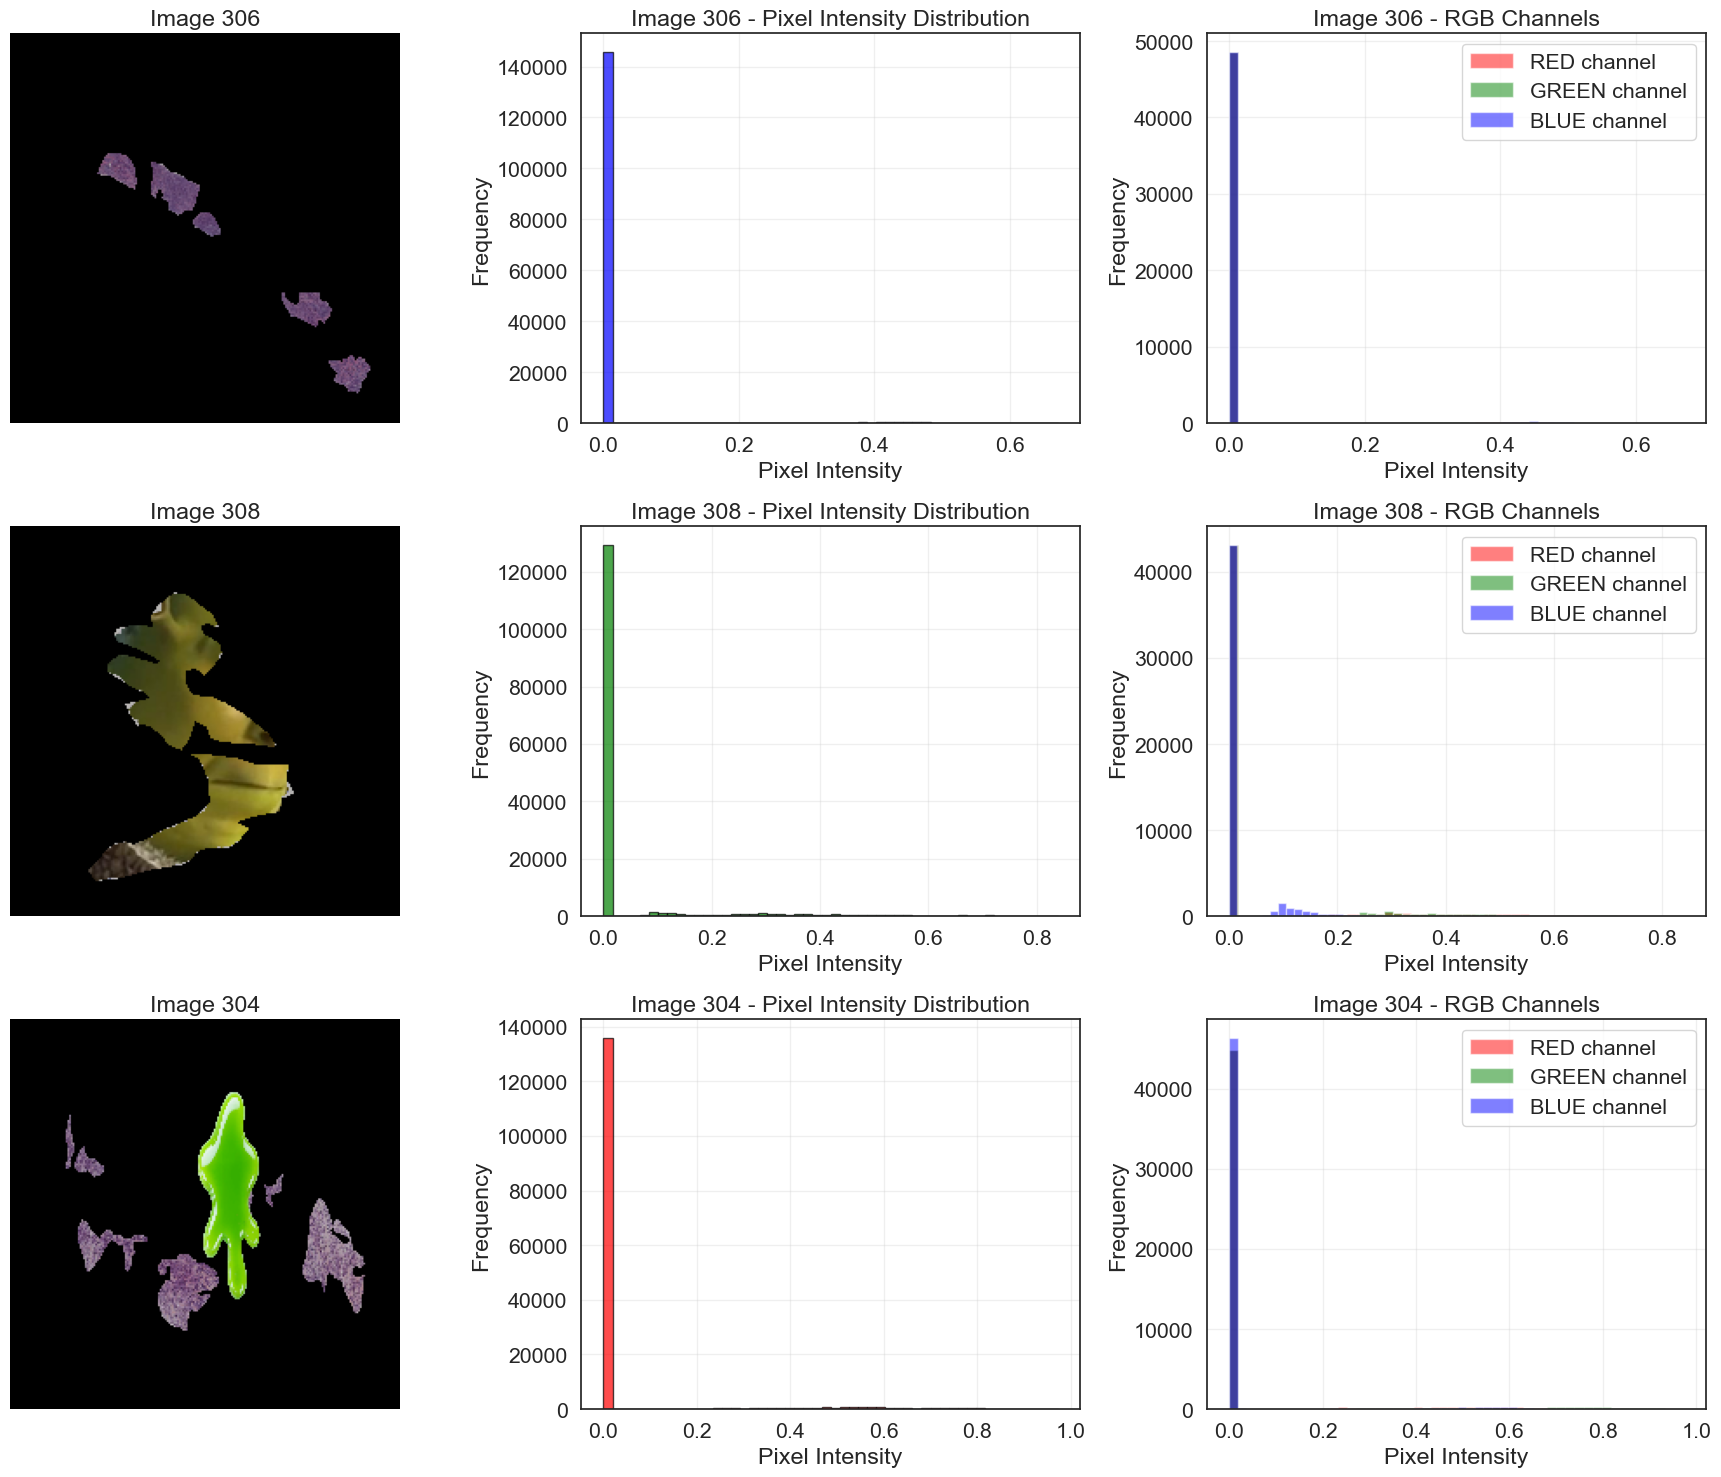

Image 306 Statistics:
  Mean intensity: 0.0126
  Std deviation: 0.0709
  Min: 0.0000, Max: 0.6706

Image 308 Statistics:
  Mean intensity: 0.0451
  Std deviation: 0.1300
  Min: 0.0000, Max: 0.8392

Image 304 Statistics:
  Mean intensity: 0.0518
  Std deviation: 0.1673
  Min: 0.0000, Max: 0.9725

Green Channel Statistics:
Image 304 - Green channel mean: 0.0633, std: 0.1943
Image 308 - Green channel mean: 0.0550, std: 0.1451

Red Channel Statistics:
Image 304 - Red channel mean: 0.0533, std: 0.1605
Image 308 - Red channel mean: 0.0587, std: 0.1562

Blue Channel Statistics:
Image 304 - Blue channel mean: 0.0388, std: 0.1419
Image 308 - Blue channel mean: 0.0215, std: 0.0666


In [253]:
# Compare pixel intensity distributions for images 306 and 308
img_306 = train_images[306]
img_308 = train_images[308]
img_304 = train_images[304]

fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Display Image 306
axes[0, 0].imshow(np.clip(img_306, 0, 1))
axes[0, 0].set_title("Image 306")
axes[0, 0].axis('off')

# Display Image 308
axes[1, 0].imshow(np.clip(img_308, 0, 1))
axes[1, 0].set_title("Image 308")
axes[1, 0].axis('off')

# Display Image 304
axes[2, 0].imshow(np.clip(img_304, 0, 1))
axes[2, 0].set_title("Image 304")
axes[2, 0].axis('off')

# Pixel intensity histogram for Image 306 (all channels combined)
axes[0, 1].hist(img_306.flatten(), bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[0, 1].set_title("Image 306 - Pixel Intensity Distribution")
axes[0, 1].set_xlabel("Pixel Intensity")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].grid(True, alpha=0.3)

# Pixel intensity histogram for Image 308 (all channels combined)
axes[1, 1].hist(img_308.flatten(), bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1, 1].set_title("Image 308 - Pixel Intensity Distribution")
axes[1, 1].set_xlabel("Pixel Intensity")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].grid(True, alpha=0.3)

# Pixel intensity histograms for Image 304
axes[2, 1].hist(img_304.flatten(), bins=50, color='red', alpha=0.7, edgecolor='black')
axes[2, 1].set_title("Image 304 - Pixel Intensity Distribution")
axes[2, 1].set_xlabel("Pixel Intensity")
axes[2, 1].set_ylabel("Frequency")
axes[2, 1].grid(True, alpha=0.3)

# RGB channel histograms for Image 306
for channel, color in enumerate(['red', 'green', 'blue']):
    axes[0, 2].hist(img_306[:, :, channel].flatten(), bins=50, 
                    color=color, alpha=0.5, label=f'{color.upper()} channel')
axes[0, 2].set_title("Image 306 - RGB Channels")
axes[0, 2].set_xlabel("Pixel Intensity")
axes[0, 2].set_ylabel("Frequency")
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# RGB channel histograms for Image 308
for channel, color in enumerate(['red', 'green', 'blue']):
    axes[1, 2].hist(img_308[:, :, channel].flatten(), bins=50, 
                    color=color, alpha=0.5, label=f'{color.upper()} channel')
axes[1, 2].set_title("Image 308 - RGB Channels")
axes[1, 2].set_xlabel("Pixel Intensity")
axes[1, 2].set_ylabel("Frequency")
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

# RGB channel histograms for Image 304
for channel, color in enumerate(['red', 'green', 'blue']):
    axes[2, 2].hist(img_304[:, :, channel].flatten(), bins=50, 
                    color=color, alpha=0.5, label=f'{color.upper()} channel')
axes[2, 2].set_title("Image 304 - RGB Channels")
axes[2, 2].set_xlabel("Pixel Intensity")
axes[2, 2].set_ylabel("Frequency")
axes[2, 2].legend()
axes[2, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("Image 306 Statistics:")
print(f"  Mean intensity: {img_306.mean():.4f}")
print(f"  Std deviation: {img_306.std():.4f}")
print(f"  Min: {img_306.min():.4f}, Max: {img_306.max():.4f}")

print("\nImage 308 Statistics:")
print(f"  Mean intensity: {img_308.mean():.4f}")
print(f"  Std deviation: {img_308.std():.4f}")
print(f"  Min: {img_308.min():.4f}, Max: {img_308.max():.4f}")

print("\nImage 304 Statistics:")
print(f"  Mean intensity: {img_304.mean():.4f}")
print(f"  Std deviation: {img_304.std():.4f}")
print(f"  Min: {img_304.min():.4f}, Max: {img_304.max():.4f}")

# Print green channel statistics for images 304 and 308
print("\nGreen Channel Statistics:")
print(f"Image 304 - Green channel mean: {img_304[:, :, 1].mean():.4f}, std: {img_304[:, :, 1].std():.4f}")
print(f"Image 308 - Green channel mean: {img_308[:, :, 1].mean():.4f}, std: {img_308[:, :, 1].std():.4f}")

# Print red channel statistics for images 304 and 308
print("\nRed Channel Statistics:")
print(f"Image 304 - Red channel mean: {img_304[:, :, 0].mean():.4f}, std: {img_304[:, :, 0].std():.4f}")
print(f"Image 308 - Red channel mean: {img_308[:, :, 0].mean():.4f}, std: {img_308[:, :, 0].std():.4f}")

# Print blue channel statistics for images 304 and 308
print("\nBlue Channel Statistics:")
print(f"Image 304 - Blue channel mean: {img_304[:, :, 2].mean():.4f}, std: {img_304[:, :, 2].std():.4f}")
print(f"Image 308 - Blue channel mean: {img_308[:, :, 2].mean():.4f}, std: {img_308[:, :, 2].std():.4f}")


Analyzing green channel frequency for all images...


Analyzing images: 100%|██████████| 1412/1412 [00:00<00:00, 3501.72it/s]




Top 20 images with highest green intensity frequency (>0.5):
Index | High Green % | Dominant Green %
--------------------------------------------------
 1134 |       13.26% |            0.01%
  602 |       11.28% |            0.02%
  436 |       10.34% |            5.00%
  223 |        9.92% |            4.95%
  442 |        9.57% |            4.96%
  964 |        9.11% |            0.01%
 1266 |        8.63% |            0.02%
  687 |        7.83% |            4.95%
  489 |        6.87% |            4.95%
 1090 |        6.69% |            0.00%
  304 |        6.40% |            4.95%
  992 |        6.37% |            4.96%
  714 |        6.35% |            4.92%
  239 |        6.24% |            4.97%
 1039 |        6.18% |            4.95%
  592 |        6.12% |            4.94%
   60 |        6.09% |            0.04%
  512 |        6.03% |            4.98%
 1054 |        6.01% |            0.01%
 1346 |        5.97% |            0.01%


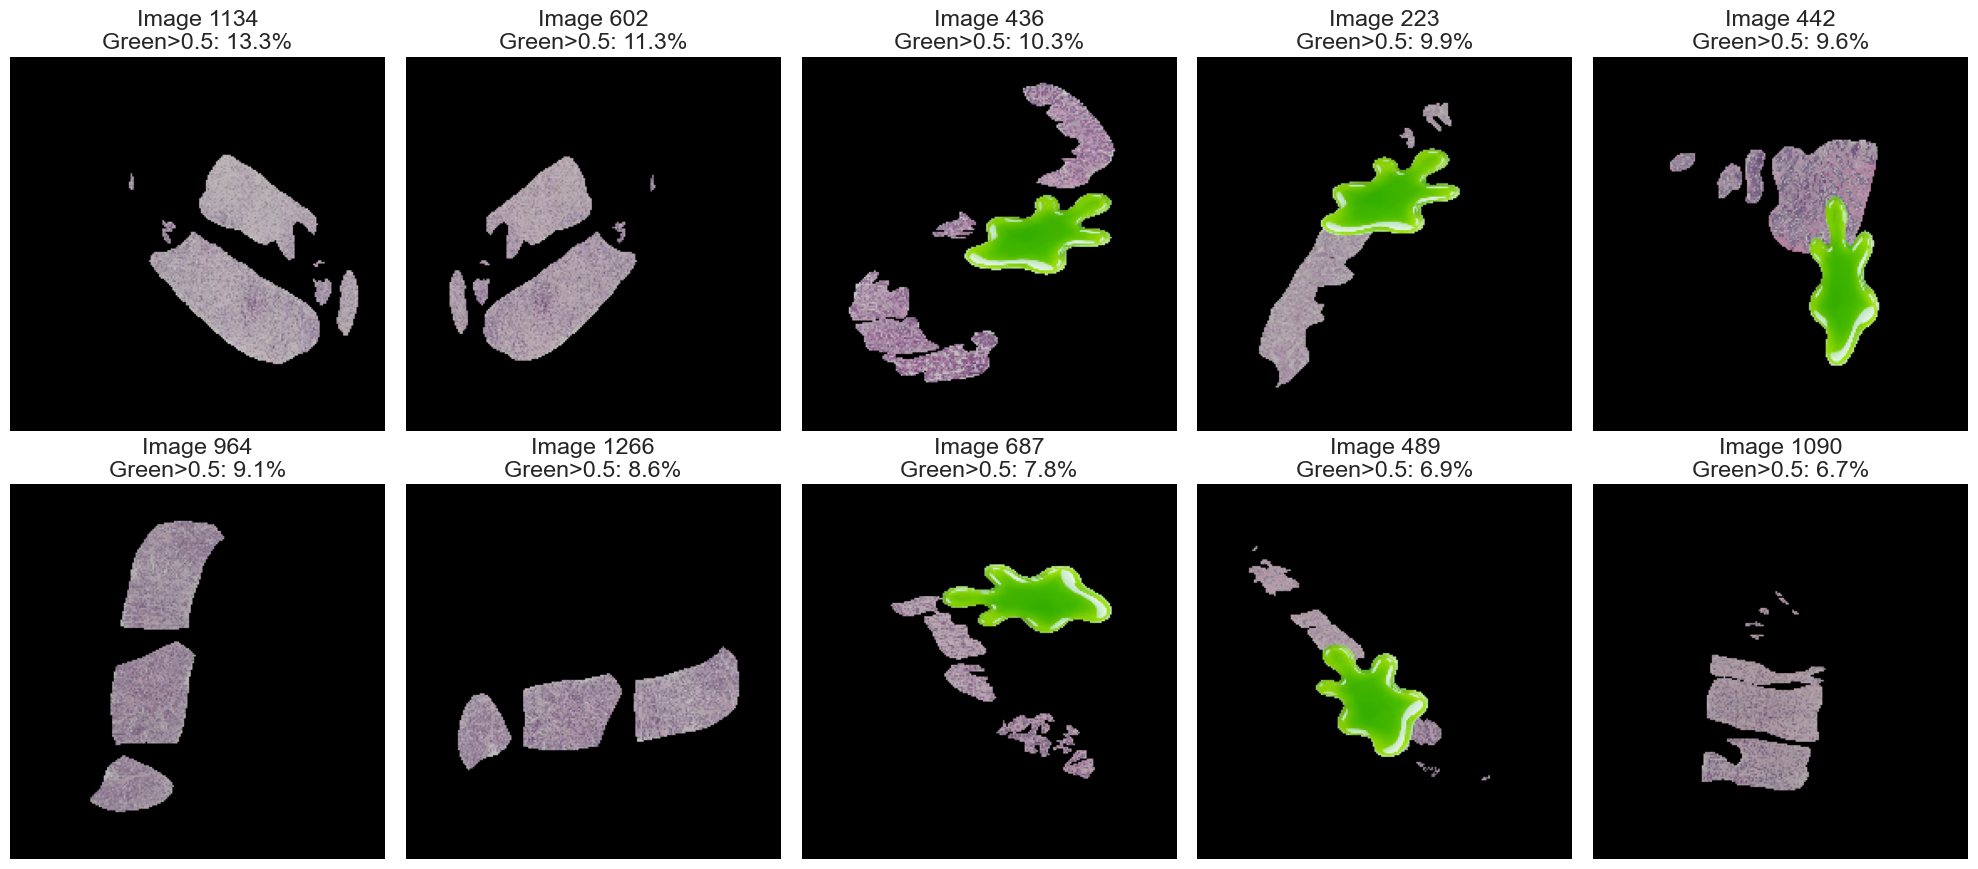


Selected 0 images with >20.0% high green intensity
Indices: []

Stored 0 images in 'selected_green_images' array
Shape: (0, 224, 224, 3)


In [254]:
# Identify images with high green channel intensity frequency
# Based on the histogram analysis, select images where green channel dominates

def analyze_green_frequency(image):
    """
    Analyze green channel frequency distribution.
    Returns the percentage of pixels where green channel has high intensity (>0.5)
    and where green is the dominant channel.
    """
    green_channel = image[:, :, 1]
    
    # Count pixels with high green intensity (>0.5)
    high_green_pixels = np.sum(green_channel > 0.5)
    
    # Count pixels where green is dominant (G > R and G > B)
    green_dominant = np.sum(
        (image[:, :, 1] > image[:, :, 0]) & 
        (image[:, :, 1] > image[:, :, 2])
    )
    
    total_pixels = image.shape[0] * image.shape[1]
    high_green_percentage = (high_green_pixels / total_pixels) * 100
    dominant_green_percentage = (green_dominant / total_pixels) * 100
    
    return high_green_percentage, dominant_green_percentage

# Analyze all images
print("Analyzing green channel frequency for all images...")
green_analysis = []
for idx, img in enumerate(tqdm(train_images, desc="Analyzing images")):
    high_green_pct, dominant_green_pct = analyze_green_frequency(img)
    green_analysis.append({
        'index': idx,
        'high_green_pct': high_green_pct,
        'dominant_green_pct': dominant_green_pct
    })

# Convert to DataFrame for easy sorting
df_green = pd.DataFrame(green_analysis)

# Sort by high green intensity percentage
df_sorted_high = df_green.sort_values('high_green_pct', ascending=False)

# Display top 20 images with highest green intensity frequency
print("\nTop 20 images with highest green intensity frequency (>0.5):")
print("Index | High Green % | Dominant Green %")
print("-" * 50)
for _, row in df_sorted_high.head(20).iterrows():
    print(f"{int(row['index']):5d} | {row['high_green_pct']:11.2f}% | {row['dominant_green_pct']:15.2f}%")

# Visualize top 10 images with highest green frequency
fig, axes = plt.subplots(2, 5, figsize=(20, 9))
axes = axes.flatten()
for i, (_, row) in enumerate(df_sorted_high.head(10).iterrows()):
    idx = int(row['index'])
    axes[i].imshow(np.clip(train_images[idx], 0, 1))
    axes[i].set_title(f"Image {idx}\nGreen>0.5: {row['high_green_pct']:.1f}%")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Select images based on threshold
green_threshold = 20.0  # Select images with >20% high green intensity
selected_green_indices = df_green[df_green['high_green_pct'] > green_threshold]['index'].values.astype(int).tolist()

print(f"\nSelected {len(selected_green_indices)} images with >{green_threshold}% high green intensity")
print(f"Indices: {selected_green_indices[:50]}")  # Show first 50

# Store the selected images
selected_green_images = train_images[selected_green_indices]
print(f"\nStored {len(selected_green_images)} images in 'selected_green_images' array")
print(f"Shape: {selected_green_images.shape}")

### Green Area Removal Filter

In [255]:
def filter_bright_green_areas(image, lg_H=60-50, lg_S=10, lg_V=50, ug_H=60+50, ug_S=255, ug_V=255, dilate_iterations=2):
    """ 
    Filters out bright green areas from the input image with improved residual removal.
    
    Args:
        image: Input image in RGB format (0-1 range)
        lg_H, lg_S, lg_V: Lower bounds for HSV green detection
        ug_H, ug_S, ug_V: Upper bounds for HSV green detection
        dilate_iterations: Number of dilation iterations to expand mask (removes edge artifacts)
    """

    # Convert from RGB (0-1) to BGR (0-255) for OpenCV
    original_bgr = (image * 255).astype(np.uint8)[..., ::-1]

    # 1. Convert to HSV (Hue, Saturation, Value)
    hsv = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2HSV)

    # 2. Define the "Bright Green" Range
    lower_green = (lg_H, lg_S, lg_V)
    upper_green = (ug_H, ug_S, ug_V)

    # Create the initial mask
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # 3. Morphological operations to clean up the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

    # OPEN: Remove small noise
    clean_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

    # DILATE: Expand the mask to catch edge artifacts and residuals
    # This ensures we remove green pixels at the boundaries
    if dilate_iterations > 0:
        clean_mask = cv2.dilate(clean_mask, kernel, iterations=dilate_iterations)

    # 4. Additional step: Detect any remaining green-ish pixels
    # Create a more aggressive mask for subtle green tones
    lower_green_subtle = (max(0, lg_H - 10), max(0, lg_S - 10), 0)
    upper_green_subtle = (min(180, ug_H + 10), 255, 255)
    subtle_mask = cv2.inRange(hsv, lower_green_subtle, upper_green_subtle)
    
    # Only keep subtle green pixels that are near the main green area
    subtle_mask = cv2.morphologyEx(subtle_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # Combine masks
    combined_mask = cv2.bitwise_or(clean_mask, subtle_mask)

    # 5. Invert mask to keep the useful parts
    mask_inv = cv2.bitwise_not(combined_mask)

    # 6. Apply the mask
    result_bgr = cv2.bitwise_and(original_bgr, original_bgr, mask=mask_inv)

    return result_bgr, combined_mask

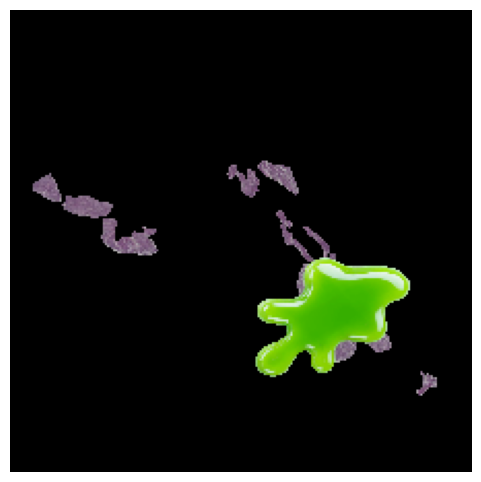

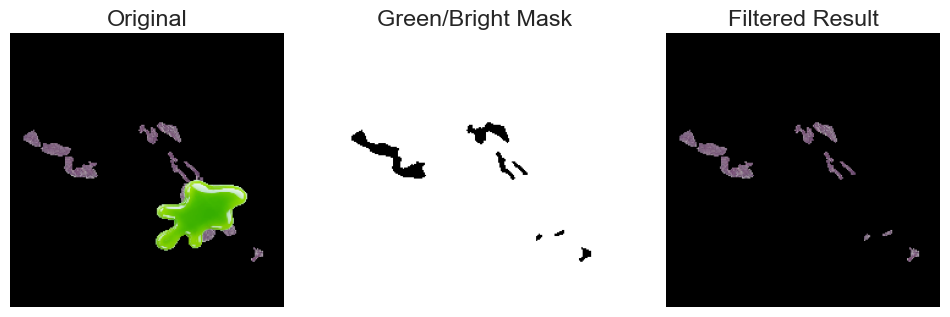

In [256]:
# Display the pixels values of an image with green areas
image_index = 102
image = train_images[image_index]
plt.figure(figsize=(6, 6))
plt.imshow(np.clip(image, 0, 1))
plt.axis('off')
plt.show()

result_bgr, clean_mask = filter_bright_green_areas(image)

# --- Display Results ---
plt.figure(figsize=(12, 6))

# Original
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(np.clip(image, 0, 1))
plt.axis('off')

# The Mask (Visualizing what we are removing)
plt.subplot(1, 3, 2)
plt.title("Green/Bright Mask")
plt.imshow(clean_mask, cmap='gray')
plt.axis('off')

# Result
result_rgb = result_bgr[..., ::-1]
plt.subplot(1, 3, 3)
plt.title("Filtered Result")
plt.imshow(np.clip(result_rgb / 255.0, 0, 1))
plt.axis('off')

plt.show()

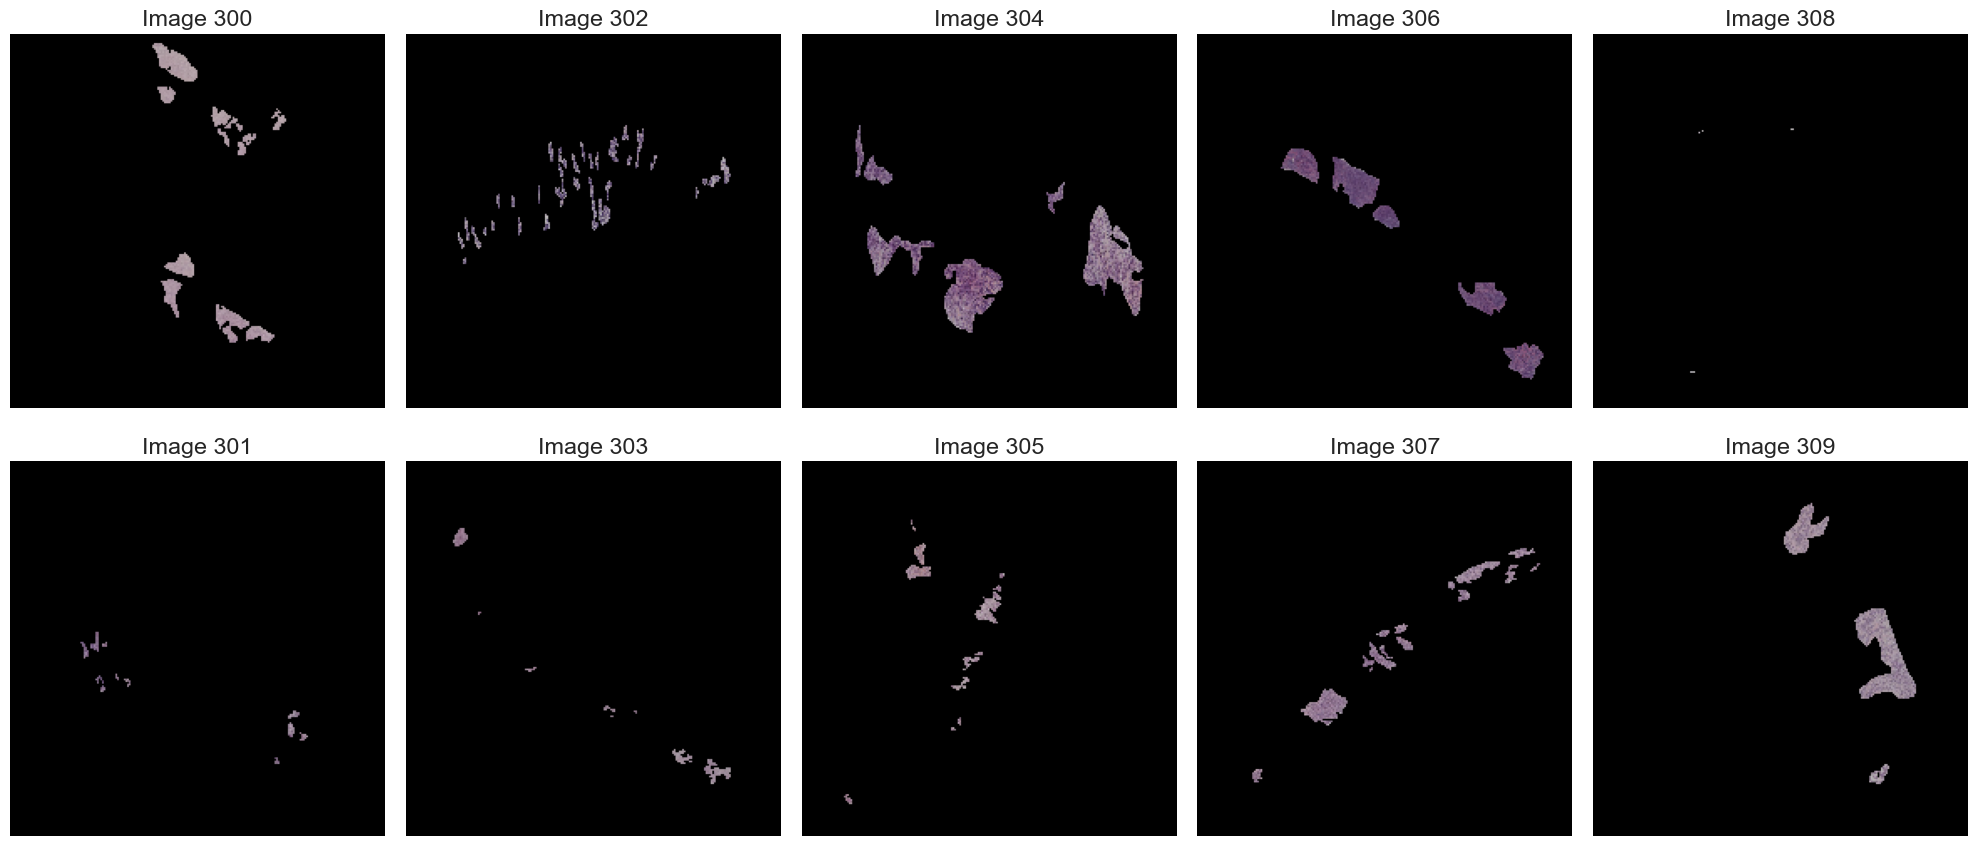

In [257]:
# Convert from BGR to RGB for displaying
result_rgb = result_bgr[..., ::-1]


# Apply the HSV filter for all the images into the training set and normalize them
for image in train_images:
    filtered_bgr, _ = filter_bright_green_areas(image)
    # Convert back to RGB and normalize to [0, 1]
    filtered_rgb = filtered_bgr[..., ::-1] / 255.0
    # Update the image in place
    image[:] = filtered_rgb

# Number of images to display
num_img = 10
start_img= 300
# Create again subplots for displaying the filtered items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(start_img, start_img+num_img):
    ax = axes[i%2, i%num_img//2]
    ax.set_title(f"Image {i}")
    ax.imshow(np.clip(train_images[i], 0, 1))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()


In [258]:
# Print RBG channel for 308 and 304 images
# Compare pixel intensity distributions for images 306 and 308
img_306 = train_images[306]
img_308 = train_images[308]

img_304 = train_images[304]

# Print green channel statistics for images 304 and 308
print("\nGreen Channel Statistics:")
print(f"Image 304 - Mean: {img_304[..., 1].mean()}, Std: {img_304[..., 1].std()}")
print(f"Image 308 - Mean: {img_308[..., 1].mean()}, Std: {img_308[..., 1].std()}")
print(f"Image 306 - Mean: {img_306[..., 1].mean()}, Std: {img_306[..., 1].std()}")

# Print blue channel statistics for images 304 and 308
print("\nBlue Channel Statistics:")
print(f"Image 304 - Mean: {img_304[..., 2].mean()}, Std: {img_304[..., 2].std()}")
print(f"Image 308 - Mean: {img_308[..., 2].mean()}, Std: {img_308[..., 2].std()}")
print(f"Image 306 - Mean: {img_306[..., 2].mean()}, Std: {img_306[..., 2].std()}")  

# Print red channel statistics for images 304 and 308
print("\nRed Channel Statistics:")
print(f"Image 304 - Mean: {img_304[..., 0].mean()}, Std: {img_304[..., 0].std()}")
print(f"Image 308 - Mean: {img_308[..., 0].mean()}, Std: {img_308[..., 0].std()}")

# Overall statistics
print("\nOverall Image Statistics After Filtering:")
print(f"Image 304 - Mean: {img_304.mean()}, Std: {img_304.std()}")
print(f"Image 308 - Mean: {img_308.mean()}, Std: {img_308.std()}")


Green Channel Statistics:
Image 304 - Mean: 0.02425665780901909, Std: 0.10095150023698807
Image 308 - Mean: 9.832058276515454e-05, Std: 0.00832502543926239
Image 306 - Mean: 0.009798841550946236, Std: 0.05465506389737129

Blue Channel Statistics:
Image 304 - Mean: 0.030743081122636795, Std: 0.12507924437522888
Image 308 - Mean: 0.00010074342571897432, Std: 0.008530670776963234
Image 306 - Mean: 0.014560042880475521, Std: 0.08036082237958908

Red Channel Statistics:
Image 304 - Mean: 0.030577542260289192, Std: 0.12503883242607117
Image 308 - Mean: 0.00010082157677970827, Std: 0.008537223562598228

Overall Image Statistics After Filtering:
Image 304 - Mean: 0.028525760397315025, Std: 0.11761248111724854
Image 308 - Mean: 9.996185690397397e-05, Std: 0.008464880287647247


In [259]:
# Remove images that have a overall mean lower or equal then 0.001
MEAN_LIMIT = 0.001
tot_eliminated_imgs = []
kept_images = []

print(f"Total images before filtering: {len(train_images)}")

for idx in range(len(train_images)):
    if train_images[idx].mean() <= MEAN_LIMIT:
        tot_eliminated_imgs.append(train_images[idx])
    else:
        kept_images.append(train_images[idx])

# Convert to numpy arrays
tot_eliminated_imgs = np.array(tot_eliminated_imgs)
train_images = np.array(kept_images)
check_correctly_removed = False                     # set it to true if you want to double check if the images were eliminated correctly

print(f"Eliminated {len(tot_eliminated_imgs)} images with mean <= {MEAN_LIMIT}")
print(f"Remaining images: {len(train_images)}")


Total images before filtering: 1412
Eliminated 170 images with mean <= 0.001
Remaining images: 1242
Eliminated 170 images with mean <= 0.001
Remaining images: 1242


In [ ]:
# Plot up to 20 eliminated images
if check_correctly_removed:
    num_to_plot = min(20, len(tot_eliminated_imgs))

    if num_to_plot > 0:
        cols = 5
        rows = (num_to_plot + cols - 1) // cols  # Calculate rows needed
        
        fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
        axes = axes.flatten() if num_to_plot > 1 else [axes]
        
        for i in range(num_to_plot):
            axes[i].imshow(np.clip(tot_eliminated_imgs[i], 0, 1))
            axes[i].set_title(f"Eliminated {i}\nMean: {tot_eliminated_imgs[i].mean():.4f}")
            axes[i].axis('off')
        
        # Hide unused subplots
        for i in range(num_to_plot, len(axes)):
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No images were eliminated.")

In [ ]:
from sklearn.preprocessing import LabelEncoder

# 1. Load the labels CSV
labels_df = pd.read_csv(train_labels_path)
# Create a dictionary mapping filename -> label for fast lookup
labels_map = dict(zip(labels_df.iloc[:, 0], labels_df.iloc[:, 1]))

# 2. Get the filenames corresponding to the images loaded in Cell 7
# IMPORTANT: This must match the order used in 'load_images_from_folder' exactly.
# We re-read the file list to ensure we have the specific names associated with the indices of 'train_images'
filenames = os.listdir(MASKED_IMAGE_PATH)

print("Aligning labels to loaded images...")

X_aligned = []
y_aligned = []

# 3. Iterate through the filenames to sync X (images) and y (labels)
# We assume 'train_images' matches the order of 'filenames' because they rely on the same os.listdir call order
# provided no files were added/deleted between Cell 7 and Cell 9.
if len(filenames) != len(train_images):
    raise ValueError(f"Mismatch! Loaded images ({len(train_images)}) != Files found ({len(filenames)}).")

for i, filename in enumerate(filenames):
    if filename in labels_map:
        # If the file exists in our CSV, keep the image and the label
        X_aligned.append(train_images[i])
        y_aligned.append(labels_map[filename])
    else:
        # If image is in folder but NOT in CSV, we must discard the image
        print(f"Skipping {filename}: Image found but no label in CSV.")

# Convert to numpy arrays
X = np.array(X_aligned)
y = np.array(y_aligned)

print(f"Images aligned: {X.shape}")
print(f"Labels aligned: {y.shape}")

# 4. Encode labels (String -> Integer)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print class mapping
print("Classes:", label_encoder.classes_)

# 5. Train-Test Split (Stratified)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=SEED,
    stratify=y_temp
)

print(f"Training data shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Labels: {y_test.shape}")

In [109]:
# Define the input shape based on the training data
input_shape = (X_train.shape[3], X_train.shape[1], X_train.shape[2])

# Define the number of classes
num_classes = len(np.unique(y_train))

print("Input Shape:", input_shape)
print("Number of Classes:", num_classes)

Input Shape: (3, 224, 224)
Number of Classes: 4


In [110]:
# Convert numpy arrays to PyTorch datasets (without augmentation for now)
train_ds = TensorDataset(
    torch.from_numpy(X_train).permute(0, 3, 1, 2),
    torch.from_numpy(y_train).squeeze().long()
)
val_ds = TensorDataset(
    torch.from_numpy(X_val).permute(0, 3, 1, 2),
    torch.from_numpy(y_val).squeeze().long()
)
test_ds = TensorDataset(
    torch.from_numpy(X_test).permute(0, 3, 1, 2),
    torch.from_numpy(y_test).squeeze().long()
)

In [111]:
# Define the batch size
BATCH_SIZE = 32

In [112]:
def make_loader(ds, batch_size, shuffle, drop_last):
    """
    Create a PyTorch DataLoader with optimized settings.

    Args:
        ds (Dataset): PyTorch Dataset object
        batch_size (int): Number of samples per batch
        shuffle (bool): Whether to shuffle data at each epoch
        drop_last (bool): Whether to drop last incomplete batch

    Returns:
        DataLoader: Configured DataLoader instance
    """
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [113]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [114]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break  # Stop after getting one batch

Features batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


## **4. Training Parameters**